#### Importing Keys and Libraries:

In [30]:
import os, getpass
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GOOGLE_API_KEY")

In [31]:
import os
from dotenv import load_dotenv
from typing import List

from pypdf import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
import google.generativeai as genai

# Load API key
load_dotenv()
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# Initialize Chroma and embedding
embedding_function = SentenceTransformerEmbeddingFunction()
chroma_client = chromadb.PersistentClient(path="./chroma_db")
collection_name = "Fynxt_database"

# Check if collection exists or create new
try:
    chroma_collection = chroma_client.get_collection(collection_name, embedding_function=embedding_function)
except:
    chroma_collection = chroma_client.create_collection(collection_name, embedding_function=embedding_function)

# Text wrapping utility (optional for CLI)
def word_wrap(text, width=100):
    import textwrap
    return "\n".join(textwrap.wrap(text, width))


#### Setting Up Database:

In [32]:
# Build knowledgebase (run once or if PDFs are updated)
def build_pdf_knowledgebase(pdf_paths: List[str]):
    all_text = []

    for path in pdf_paths:
        reader = PdfReader(path)
        text_content = [p.extract_text().strip() for p in reader.pages if p.extract_text()]
        all_text.extend(text_content)

    combined_text = '\n\n'.join(all_text)

    # Step 1: Character-level splitting
    character_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", ". ", " ", ""],
        chunk_size=2000,
        chunk_overlap=200
    )
    character_chunks = character_splitter.split_text(combined_text)

    # Step 2: Token-level splitting
    token_splitter = SentenceTransformersTokenTextSplitter(tokens_per_chunk=256, chunk_overlap=20)
    token_chunks = []
    for text in character_chunks:
        token_chunks += token_splitter.split_text(text)

    # Filter short/empty chunks
    token_chunks = [chunk for chunk in token_chunks if len(chunk.strip()) > 30]

    # Store in ChromaDB
    ids = [str(i) for i in range(len(token_chunks))]
    metadatas = [{"source": f"{os.path.basename(path)}_chunk_{i}"} for i in range(len(token_chunks))]
    chroma_collection.add(ids=ids, documents=token_chunks, metadatas=metadatas)

    print(f"✅ Knowledgebase built with {len(token_chunks)} chunks.")

# Run once to build
build_pdf_knowledgebase(["G:/Fyxt_CS/Docs/Final_Doc.pdf"])

✅ Knowledgebase built with 8 chunks.


#### Tools/Functoins:

In [33]:
from langchain_core.tools import tool
import random

# Query function
@tool
def query_pdf_knowledgebase(query: str) -> str:
    """
    Answers a user's query based on pre-loaded documentation in ChromaDB.

    """
    model = genai.GenerativeModel("gemini-1.5-flash-8b")
    results = chroma_collection.query(query_texts=[query], n_results=5)
    retrieved_documents = results['documents'][0]

    if not retrieved_documents:
        return "⚠️ No relevant information found."

    context = "\n\n".join([doc.strip() for doc in retrieved_documents])

    prompt = (
        "You are a helpful customer support assistant. Your users are asking questions about specific feature of the financial software."
        "Use only the provided content to answer accurately.\n\n"
        f"Question: {query}\n\n"
        f"Information:\n{context}"
    )

    response = model.generate_content(prompt)
    return response.text

@tool
def generate_support_ticket(question: str) -> str:
    """
    Generates a support ticket when no relevant documentation is found.
    """
    ticket_id = f"TICKET-{random.randint(1000, 9999)}"
    return (
        f"✅ Ticket created!\n\n"
        f"📄 **Ticket ID**: {ticket_id}\n"
        f"📝 **Question**: {question}\n"
        f"A customer support rep will follow up with you soon."
    )



#### Model Initialization & Tool Binding:

In [34]:
import base64
from typing import List
from langchain.schema import HumanMessage
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-8b")

tools = [query_pdf_knowledgebase, generate_support_ticket]

llm_with_tools = llm.bind_tools(tools)

#### Agent Workflow:

In [35]:
from typing import TypedDict, Annotated, List, Any, Optional
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.utils.function_calling import convert_to_openai_tool

class AgentState(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]

# AgentState
def assistant(state: AgentState) -> AgentState:
    messages = state["messages"]
    
    # Optional: Add system prompt (helps steer behavior)
    system_prompt = SystemMessage(content=(
    "You are a helpful customer support agent. "
    "Use the knowledge base to answer the user's question. "
    "If no relevant information is found, ask the user if they want to raise a ticket. "
    "If they say yes, use the 'generate_support_ticket' tool with their original question."
    ))

    # Run LLM with tool support
    response = llm_with_tools.invoke([system_prompt] + messages)

    return {
        "messages": messages + [response]
    }


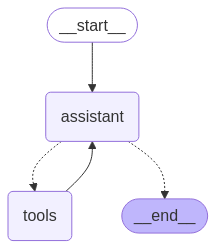

In [36]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile(name="CustomerSupportAgent")

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

#### Agentic RAG:

In [37]:
messages = [HumanMessage(content="How can I enable or disable fee structures for PAMM?")]

final_state = react_graph.invoke({"messages": messages})

In [38]:
for m in final_state['messages']:
    m.pretty_print()

if "ticket" in final_state:
    print("\n🎫 Ticket info:", final_state["ticket"])

================================ Human Message =================================

How can I enable or disable fee structures for PAMM?
================================== Ai Message ==================================
Tool Calls:
  query_pdf_knowledgebase (a74fd4c4-14cb-4b20-b363-7f586a050876)
 Call ID: a74fd4c4-14cb-4b20-b363-7f586a050876
  Args:
    query: How can I enable or disable fee structures for PAMM?
================================= Tool Message =================================
Name: query_pdf_knowledgebase

To enable or disable fee structures for PAMM, go to Settings > Platform Configuration > Managed Accounts, select the "Managers" tab, and toggle the "Fee Structure" option.  If enabled, only the administrator can define fee structures.  If disabled, fund managers can define their own fee structures, which the administrator can then approve.

================================== Ai Message ==================================

To enable or disable fee structures for PAMM, go to

#### Without Memory:

In [39]:
messages = [HumanMessage(content="I want to setup account for my MT4, how to do that?")]
final_state = react_graph.invoke({"messages": messages})
for m in final_state['messages']:
    m.pretty_print()

if "ticket" in final_state:
    print("\n🎫 Ticket info:", final_state["ticket"])

================================ Human Message =================================

I want to setup account for my MT4, how to do that?
================================== Ai Message ==================================
Tool Calls:
  query_pdf_knowledgebase (3884886c-8f06-43f7-9351-a5b527098c2b)
 Call ID: 3884886c-8f06-43f7-9351-a5b527098c2b
  Args:
    query: How to set up an MT4 account?
================================= Tool Message =================================
Name: query_pdf_knowledgebase

There is no information on how to set up an MT4 account in the provided text.

================================== Ai Message ==================================

I'm sorry, I couldn't find any information about setting up an MT4 account in the available knowledge base.  Would you like to raise a support ticket?


In [40]:
messages = [HumanMessage(content="Yes please!")]
final_state = react_graph.invoke({"messages": messages})
for m in final_state['messages']:
    m.pretty_print()

if "ticket" in final_state:
    print("\n🎫 Ticket info:", final_state["ticket"])

================================ Human Message =================================

Yes please!
================================== Ai Message ==================================

OK.  Please provide your question.


#### With Memory:

In [41]:
# Start conversation
messages = [HumanMessage(content="I want to setup account for my MT4, how to do that?")]
final_state = react_graph.invoke({"messages": messages})
for m in final_state['messages']:
    m.pretty_print()


================================ Human Message =================================

I want to setup account for my MT4, how to do that?
================================== Ai Message ==================================
Tool Calls:
  query_pdf_knowledgebase (b7ebc593-4592-4b8a-9b69-fb6c13ddccdc)
 Call ID: b7ebc593-4592-4b8a-9b69-fb6c13ddccdc
  Args:
    query: How to setup an MT4 account?
================================= Tool Message =================================
Name: query_pdf_knowledgebase

The provided text does not contain instructions on how to set up an MT4 account.  There are instructions for configuring various aspects of PAMM accounts, but nothing about MT4.

================================== Ai Message ==================================

I'm sorry, I couldn't find any information about setting up an MT4 account in the available documentation.  Would you like to raise a support ticket?


In [ ]:
# Accumulate messages
messages = final_state["messages"]

# Now user says "Yes please!"
messages += [HumanMessage(content="Yes please!")]
final_state = react_graph.invoke({"messages": messages})
for m in final_state["messages"]:
    m.pretty_print()

================================ Human Message =================================

I want to setup account for my MT4, how to do that?
================================== Ai Message ==================================
Tool Calls:
  query_pdf_knowledgebase (b7ebc593-4592-4b8a-9b69-fb6c13ddccdc)
 Call ID: b7ebc593-4592-4b8a-9b69-fb6c13ddccdc
  Args:
    query: How to setup an MT4 account?
================================= Tool Message =================================
Name: query_pdf_knowledgebase

The provided text does not contain instructions on how to set up an MT4 account.  There are instructions for configuring various aspects of PAMM accounts, but nothing about MT4.

================================== Ai Message ==================================

I'm sorry, I couldn't find any information about setting up an MT4 account in the available documentation.  Would you like to raise a support ticket?
================================ Human Message =================================

Yes plea

#### Chat Interface:

In [55]:
# session memory
chat_history = []

def chat_with_bot(user_input):
    global chat_history

    # Append user message
    chat_history.append(HumanMessage(content=user_input))

    # Run through LangGraph
    final_state = react_graph.invoke({"messages": chat_history})

    # Update memory
    chat_history = final_state["messages"]

    # Extract latest assistant message
    last_message = chat_history[-1]
    return last_message.content

import gradio as gr

with gr.Blocks() as demo:
    gr.Markdown("## 🤖 Fynxt Support Assistant")

    chatbot = gr.Chatbot()
    with gr.Row():
        msg = gr.Textbox(placeholder="Ask me about PAMM, MT4, fees, etc...", show_label=False)
        clear = gr.Button("Clear")

    def respond(message, history):
        response = chat_with_bot(message)
        history.append((message, response))
        return "", history

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(lambda: ([], []), None, [chatbot, msg])

demo.launch(share=True)


C:\Users\Admin\AppData\Local\Temp\ipykernel_11984\740186185.py:25: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


* Running on local URL:  http://127.0.0.1:7861
* Running on public URL: https://b7f9cc201eb86c7e9e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [56]:
demo.close()

Closing server running on port: 7861
